In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.legend_handler import HandlerTuple
from matplotlib.container import Container
import pandas as pd
import numpy as np
import os, requests, tarfile, zipfile, io
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, io
# from style import output_folder, big_fontsize, base_width, base_height, dpi
import seaborn as sns
import json
from astropy.time import Time
from style import *
from LC import candidates_lc_dir, get_lc, names

In [3]:

def plot_lc(name, sigma=5):
    
    jdass, jdice, data, nu_name, ttype = get_lc(name)
    fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
    conts = list()
    labels = list()
    for band, d in data.items():
        
        if 'corrupted' in band:
            continue
        
#         m = np.array([i in corrupted for i in d.IMAGE])
#         d = d[~m]
        
        jd = d['JD'] - jdass
        mag = d['mag']
        err = d['mag_err']
        
        if len(jd):
            errm = (d['flux(mJy)'] < d.flux_err * sigma) | (err == 99.99)
#             cont1 = ax.errorbar(jd[~errm], mag[~errm], yerr=err[~errm], color=bandcols[band], ls='',
#                         markeredgecolor='k', ecolor='k', markersize=3, capsize=2, marker=bandmark[band], mew=0.5, elinewidth=0.5)
            cont1 = ax.errorbar(jd[~errm], mag[~errm], yerr=err[~errm], color=bandcols[band], marker=bandmark[band], **lc_errbar_kw)
#             cont2,  = ax.plot(jd[errm], mag[errm], marker='v', color=bandcols[band], ls='', markersize=2, 
#                                  mfc=None, markeredgecolor=bandcols[band], mew=0.5, fillstyle='none', zorder=0)
            cont2,  = ax.plot(jd[errm], mag[errm], color=bandcols[band], markeredgecolor=bandcols[band], **lc_uplim_kw)
            conts.append((cont1, cont2))
            labels.append(f"{band}, upper limits")

    ylim = ax.get_ylim()
    ax.set_ylim([ylim[1], ylim[0]])
    ax.set_ylabel('magnitude')
    mjd_ass = Time(jdass[0], format='jd').mjd
    mjd_ice = Time(jdice[0], format='jd').mjd
    ax.set_xlabel(f'MJD - {mjd_ass:.0f}')
    line = ax.axvline(mjd_ice-mjd_ass)
    ax.legend([line] + conts, [nu_name] + labels, handler_map={tuple: HandlerTuple(ndivide=None)})
    ax.set_title(name)
    fig.tight_layout()
    return fig, ax

In [4]:
jdass, jdice, data, nu_name, ttype = get_lc('AT2020rng')
np.any(data['g'].IMAGE == 'coadd_bE242641')

no data for AT2020rng for V


False

In [5]:
def get_ztffps_at2020rng():
    tab = io.ascii.read('data/at2020rng_ztffps.txt')
    names = list(tab[0])
    names[6] ='info'
    names = [i.strip(',') for i in names]
    tab = io.ascii.read('data/at2020rng_ztffps.txt', names=names)[1:]
    tab = tab[tab['programid'] == '1']
    tab = tab[~(tab['forcediffimflux'] == 'null')]

    jdass, jdice, data, nu_name, ttype = get_lc('AT2020rng')
    f = np.array(tab['forcediffimflux']).astype(float)
    fu = np.array(tab['forcediffimfluxunc']).astype(float)
    zp = np.array(tab['zpdiff']).astype(float)
    t = np.array(tab['jd']).astype(float) - jdass
    fltr = tab['filter']

    m = f/fu > 5
    print(f"{sum(m)} detections")
    tab = tab

    mag = np.zeros(len(tab))
    mage = np.zeros(len(tab))
    
    mag[m] = zp[m] - 2.5*np.log10(f[m])
    mage[m] = 1.0857* fu[m] / f[m]
    
    mag[~m] = zp[~m] - 2.5 * np.log10(5 * fu[~m])
    mage[~m] = 99.99
    return t, mag, mage, fltr

no data for AT2020rng for V
no data for AT2020rng for V
13 detections


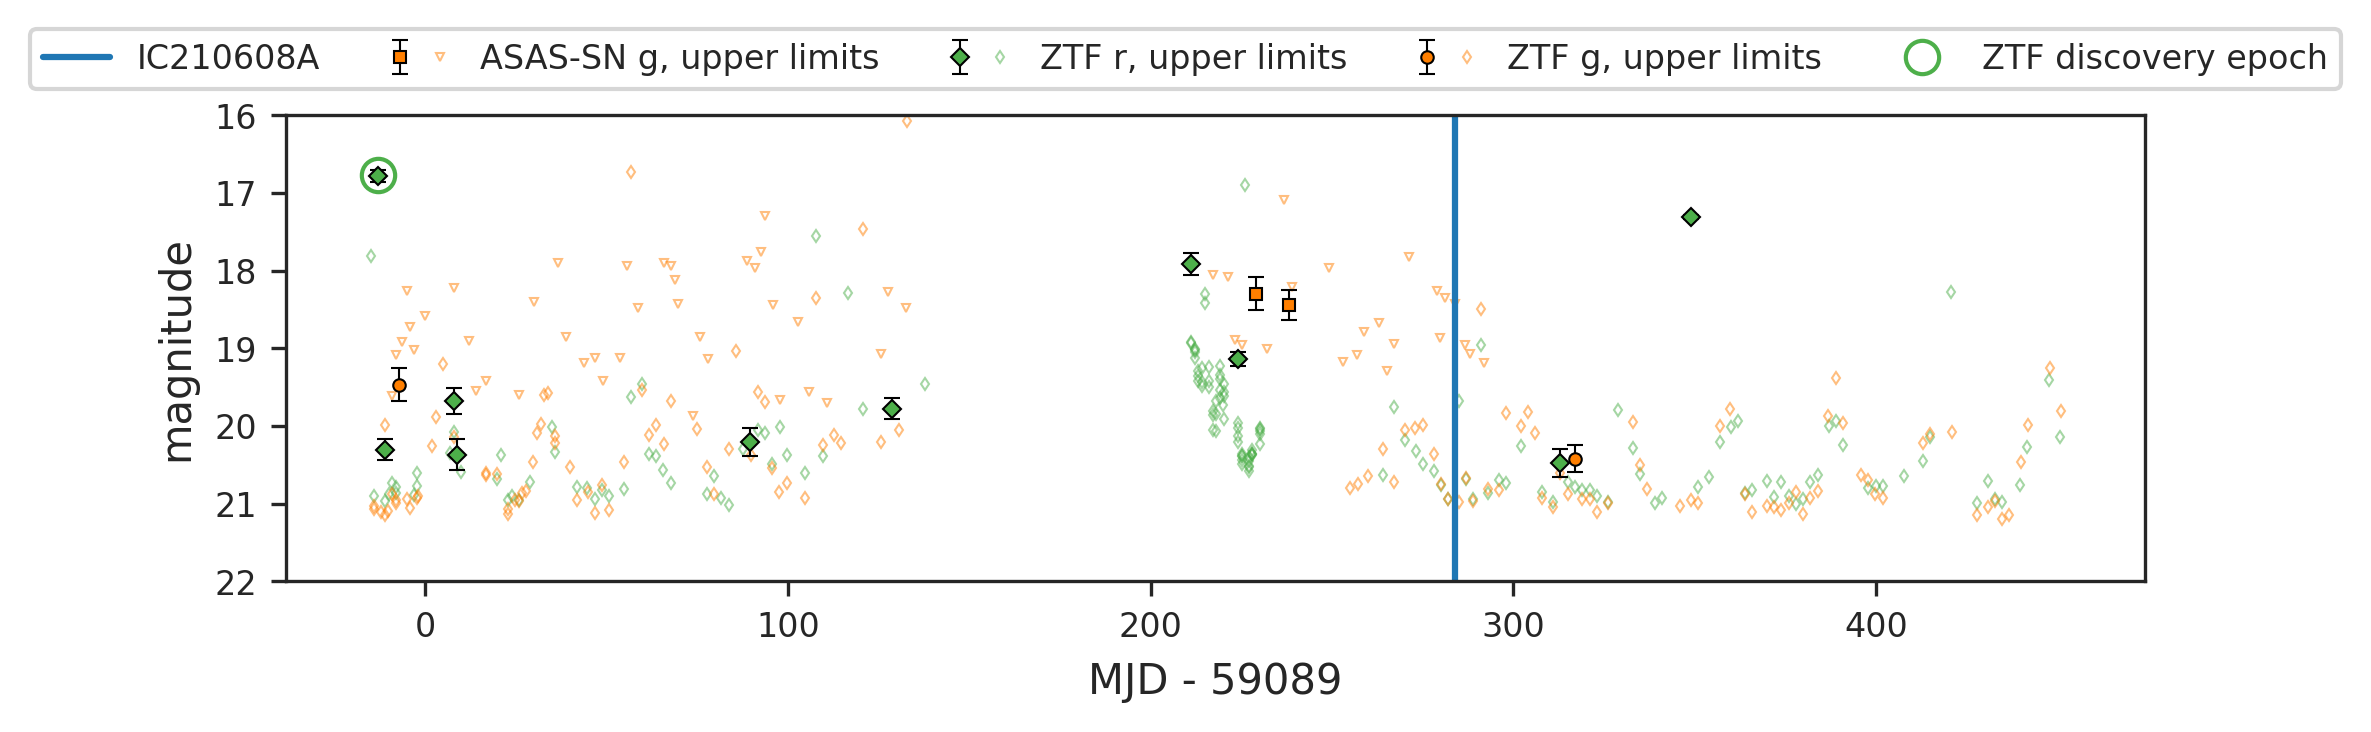

In [53]:
jdass, jdice, data, nu_name, ttype = get_lc('AT2020rng')
fig, ax = plt.subplots(figsize=(base_width*2, base_height), dpi=dpi)
conts = list()
labels = list()
sigma = 5
for band, d in data.items():

    if 'corrupted' in band:
        continue

    jd = d['JD'] - jdass
    mag = d['mag']
    err = d['mag_err']

    if len(jd):
        errm = (d['flux(mJy)'] < d.flux_err * sigma) | (err == 99.99)
        cont1 = ax.errorbar(jd[~errm], mag[~errm], yerr=err[~errm], color=bandcols[band], marker=bandmark[band], **lc_errbar_kw)
        cont2,  = ax.plot(jd[errm], mag[errm], color=bandcols[band], markeredgecolor=bandcols[band], **lc_uplim_kw)
        conts.append((cont1, cont2))
        labels.append(f"ASAS-SN {band}, upper limits")

t, mag, mage, fltr = get_ztffps_at2020rng()
ulm = mage == 99.99

for f in ['r', 'g']:
    m = fltr == f'ZTF_{f}'
    m = m & (t > -15) & (t < 2000)
    kw = dict(lc_errbar_kw)
    kw['ecolor'] = 'k'
    kw['markeredgecolor'] = 'k'
    if np.any(m &~ ulm):
        marker = {'g': 'o', 'r': 'D'}[f]
        cont1 = ax.errorbar(t[m &~ ulm], mag[m & ~ ulm], yerr=mage[m &~ ulm], color=bandcols[f], marker=marker,  label=f"ZTF {f}", **kw)
    else:
        cont1=None
    ztf_ulim_kw = dict(lc_uplim_kw)
    ztf_ulim_kw['marker'] = 'd'    
    cont2, = ax.plot(t[m & ulm], mag[m & ulm], color=bandcols[f], label=f"ZTF {f} upper limits",
                    **ztf_ulim_kw)
    if cont1:
        conts.append((cont1, cont2))
        labels.append(f"ZTF {f}, upper limits")
    else:
        conts.append((cont2))
        labels.append(f"ZTF {f} upper limits")
        
# w = 0.4
# h = 0.4
# rect = [0.7-w/2,0.3-w/2,w,h]
# box = ax.get_position()
# width = box.width
# height = box.height
# inax_position  = ax.transAxes.transform(rect[0:2])
# transFigure = fig.transFigure.inverted()
# infig_position = transFigure.transform(inax_position) 
# x = infig_position[0]
# y = infig_position[1]
# width *= rect[2]
# height *= rect[3]
# smallax = fig.add_axes([x, y, width, height])


disc_time = Time('2020-08-15 08:06:00.000').jd - jdass
cont4, = ax.plot(disc_time, 16.77, marker='o', color=bandcols['r'], mfc='none', ms=8, label='ZTF discovery', ls='')
conts.append(cont4)
labels.append(f"ZTF discovery epoch")

ylim = ax.get_ylim()
ax.set_ylim([ylim[1], ylim[0]])
ax.set_ylabel('magnitude')
mjd_ass = Time(jdass[0], format='jd').mjd
mjd_ice = Time(jdice[0], format='jd').mjd
ax.set_xlabel(f'MJD - {mjd_ass:.0f}')
line = ax.axvline(mjd_ice-mjd_ass)
ax.legend([line] + conts, [nu_name] + labels, handler_map={tuple: HandlerTuple(ndivide=None)},
          bbox_to_anchor = (0.5,0.99), bbox_transform = fig.transFigure, loc='upper center', ncol=5)
ax.set_title('')
fig.tight_layout()

ax.set_ylim([22, 16])

fig.savefig(f"{candidates_lc_dir}/at2020rng.pdf", bbox_inches='tight')

plt.show()
plt.close()

In [7]:
inax_position  = ax.transAxes.transform([0.2,0.2,0.7,0.7][0:2])
transFigure = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)  
infig_position

array([0.30401389, 0.33523833])

In [8]:
for n in names:
    fig, ax = plot_lc(n)
    fn = f'{candidates_lc_dir}/{n}.pdf'
    print(f"saving {n} under {fn}")
    fig.savefig(fn)
    plt.close()

no data for AT2020rng for V
saving AT2020rng under ../figures/candidates_lightcurves/AT2020rng.pdf
no data for AT2020idu for V
saving AT2020idu under ../figures/candidates_lightcurves/AT2020idu.pdf
no data for AT2019fxr for V
saving AT2019fxr under ../figures/candidates_lightcurves/AT2019fxr.pdf
no data for AT2019dsg for V
saving AT2019dsg under ../figures/candidates_lightcurves/AT2019dsg.pdf
no data for SN2019aah for V
saving SN2019aah under ../figures/candidates_lightcurves/SN2019aah.pdf
saving AT2018dyd under ../figures/candidates_lightcurves/AT2018dyd.pdf
saving SN2018coq under ../figures/candidates_lightcurves/SN2018coq.pdf
saving AT2017hzv under ../figures/candidates_lightcurves/AT2017hzv.pdf


AT2020rng
no data for AT2020rng for V
AT2019fxr
no data for AT2019fxr for V
AT2019dsg
no data for AT2019dsg for V
SN2019aah
no data for SN2019aah for V
SN2018coq
AT2017hzv


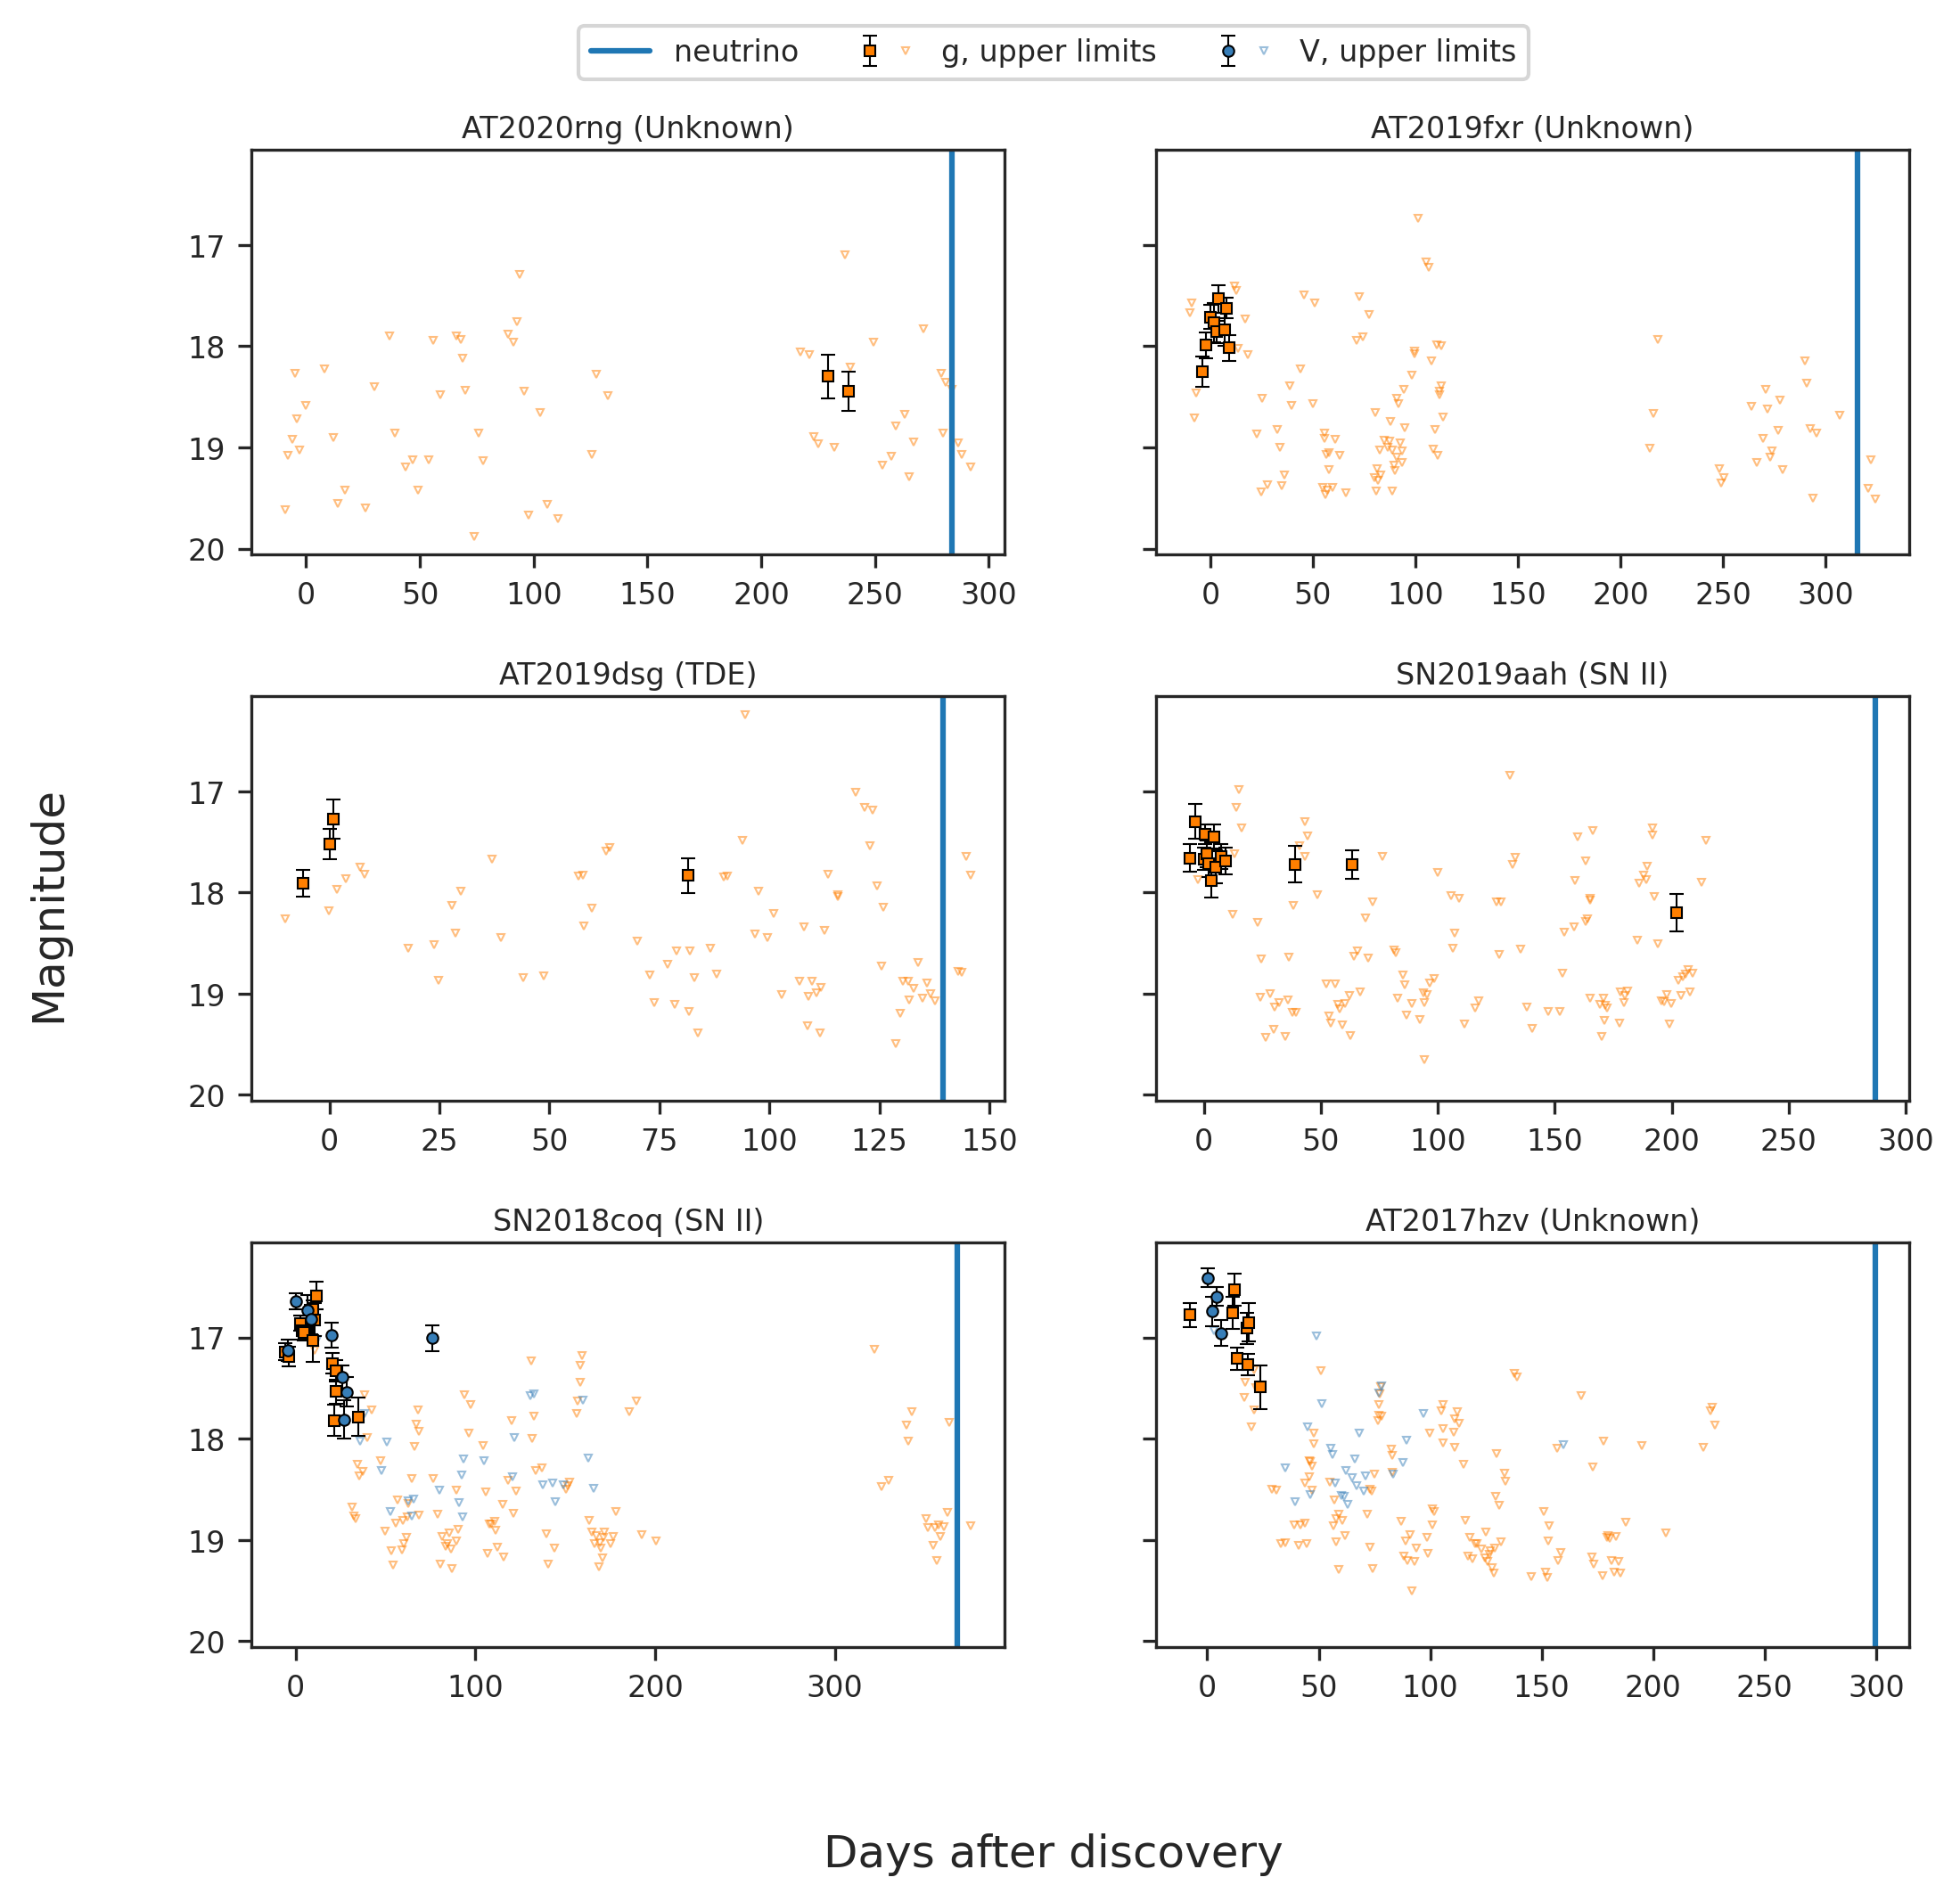

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(base_width*2, base_height*3), dpi=dpi, sharey='all', gridspec_kw={'hspace':0.35})
sigma=5
ylims = list()
inds = [0, 2, 3, 4, 6, 7]
for i, j in enumerate(inds):
    name = names[j]
    ax = axs.flatten()[i]
    if name == 'AT2020idu':
        continue

    print(name)
    jdass, jdice, data, nu_name, ttype = get_lc(name)
    #fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
    conts = list()
    labels = list()
    for band, d in data.items():
        if 'corrupted' in band:
            continue
        
        jd = d['JD'] - jdass
        mag = d['mag']
        err = d['mag_err']
        
        if len(jd):
            errm = (d['flux(mJy)'] < d.flux_err * sigma) | (err == 99.99)
            cont1 = ax.errorbar(jd[~errm], mag[~errm], yerr=err[~errm], color=bandcols[band], marker=bandmark[band], **lc_errbar_kw)
            cont2,  = ax.plot(jd[errm], mag[errm], color=bandcols[band], **lc_uplim_kw)
            conts.append((cont1, cont2))
            labels.append(f"{band}, upper limits")
            
    if name == '_AT2020rng':
        t, mag, mage, fltr = get_ztffps_at2020rng()
        ulm = mage == 99.99
        for f in ['r', 'g']:
            m = fltr == f'ZTF_{f}'
            m = m & (t > -15) & (t < -11)
            kw = dict(lc_errbar_kw)
            kw['ecolor'] = None
            kw['markeredgecolor'] = None
#             kw['alpha'] = 0.5
            if np.any(m &~ ulm):
                ax.errorbar(t[m &~ ulm], mag[m & ~ ulm], yerr=mage[m &~ ulm], color=bandcols[f], marker=bandmark[f],  label=f"ZTF {f}", **kw)
            ax.scatter(t[m & ulm], mag[m & ulm], color=bandcols[f], marker='d', s=2, alpha=1, label=f"ZTF {f} upper limits")
            
        
        disc_time = Time('2020-08-15 08:06:00.000').jd - jdass
        ax.scatter(disc_time, 16.6717, marker='o', color=bandcols['r'], facecolors='none', s=70, label='ZTF discovery')
        ax.legend(ncol=2, loc='lower center')

    ylims.append(ax.get_ylim())
#     ax.set_ylim([ylim[1], ylim[0]])
#     ax.set_ylabel('magnitude')
    mjd_ass = Time(jdass[0], format='jd').mjd
    mjd_ice = Time(jdice[0], format='jd').mjd
#     ax.set_xlabel(f'MJD - {mjd_ass:.0f}')
    line = ax.axvline(mjd_ice-mjd_ass)
#     ax.legend([line] + conts, [nu_name] + labels, handler_map={tuple: HandlerTuple(ndivide=None)})
#     ax.set_title(name, fontsize=big_fontsize-2)
    ax.text(.5,1.03, f'{name} ({ttype})',
        horizontalalignment='center',
        transform=ax.transAxes, fontsize=big_fontsize-2)
#     ax.grid()
    
# fig.text(0.5, 0.04, 'common X', ha='center')
# fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
ylims = np.array(ylims)
axs[0][0].set_ylim(max(ylims[:,1]), min(ylims[:,0]))
#axs.flatten()[-1].axis('off')

fig.supxlabel('Days after discovery')
fig.supylabel('Magnitude')

fig.legend([line] + conts, ['neutrino'] + labels, handler_map={tuple: HandlerTuple(ndivide=None)}, bbox_to_anchor = (0.5,0.95),
            bbox_transform = fig.transFigure, loc='upper center', ncol=3)
# fig.tight_layout(pad=2)
fig.savefig(f'{candidates_lc_dir}/combined.pdf')
plt.show()
plt.close()


In [134]:
jdass, jdice, data, nu_name, ttype = get_lc('AT2020rng')
t, mag, mage, fltr = get_ztffps_at2020rng()
ztfdat = pd.DataFrame({f'JD - {jdass[0]:.1f}': t, 'JD': t+jdass, 'mag': mag, 'emag': mage, 'filter': fltr})

no data for AT2020rng for V
no data for AT2020rng for V
13 detections


In [136]:
ztfdat.loc[65:75]

,JD - 2459089.9,JD,mag,emag,filter
65,-16.058530,2.459074e+06,21.076439,99.990000,ZTF_g
66,-14.990451,2.459075e+06,17.808170,99.990000,ZTF_r
67,-14.069491,2.459076e+06,20.903979,99.990000,ZTF_r
68,-14.048692,2.459076e+06,21.035093,99.990000,ZTF_g
69,-14.013426,2.459076e+06,21.075864,99.990000,ZTF_g
70,-13.062465,2.459077e+06,16.784696,0.074839,ZTF_r
71,-12.038113,2.459078e+06,21.115463,99.990000,ZTF_g
72,-11.092917,2.459079e+06,20.306288,0.132422,ZTF_r
73,-11.063449,2.459079e+06,20.971868,99.990000,ZTF_r
74,-11.038738,2.459079e+06,21.147123,99.990000,ZTF_g


In [51]:
def F(t):
    F0 = 1
    tpp = 2
    return F0 * (1 / (1 + t/tpp))

F(1)

0.6666666666666666

In [ ]:
fermi_matches = pd.read_csv("data/fermi_matches.csv", index_col=[0,1,2])
def get_fermi_lc(name):
    m = fermi_matches.Counterpart == name
    

AT2020rng
no data for AT2020rng for V
AT2020idu
no data for AT2020idu for V
AT2019fxr
no data for AT2019fxr for V
AT2019dsg
no data for AT2019dsg for V
SN2019aah
no data for SN2019aah for V
AT2018dyd
SN2018coq
AT2017hzv


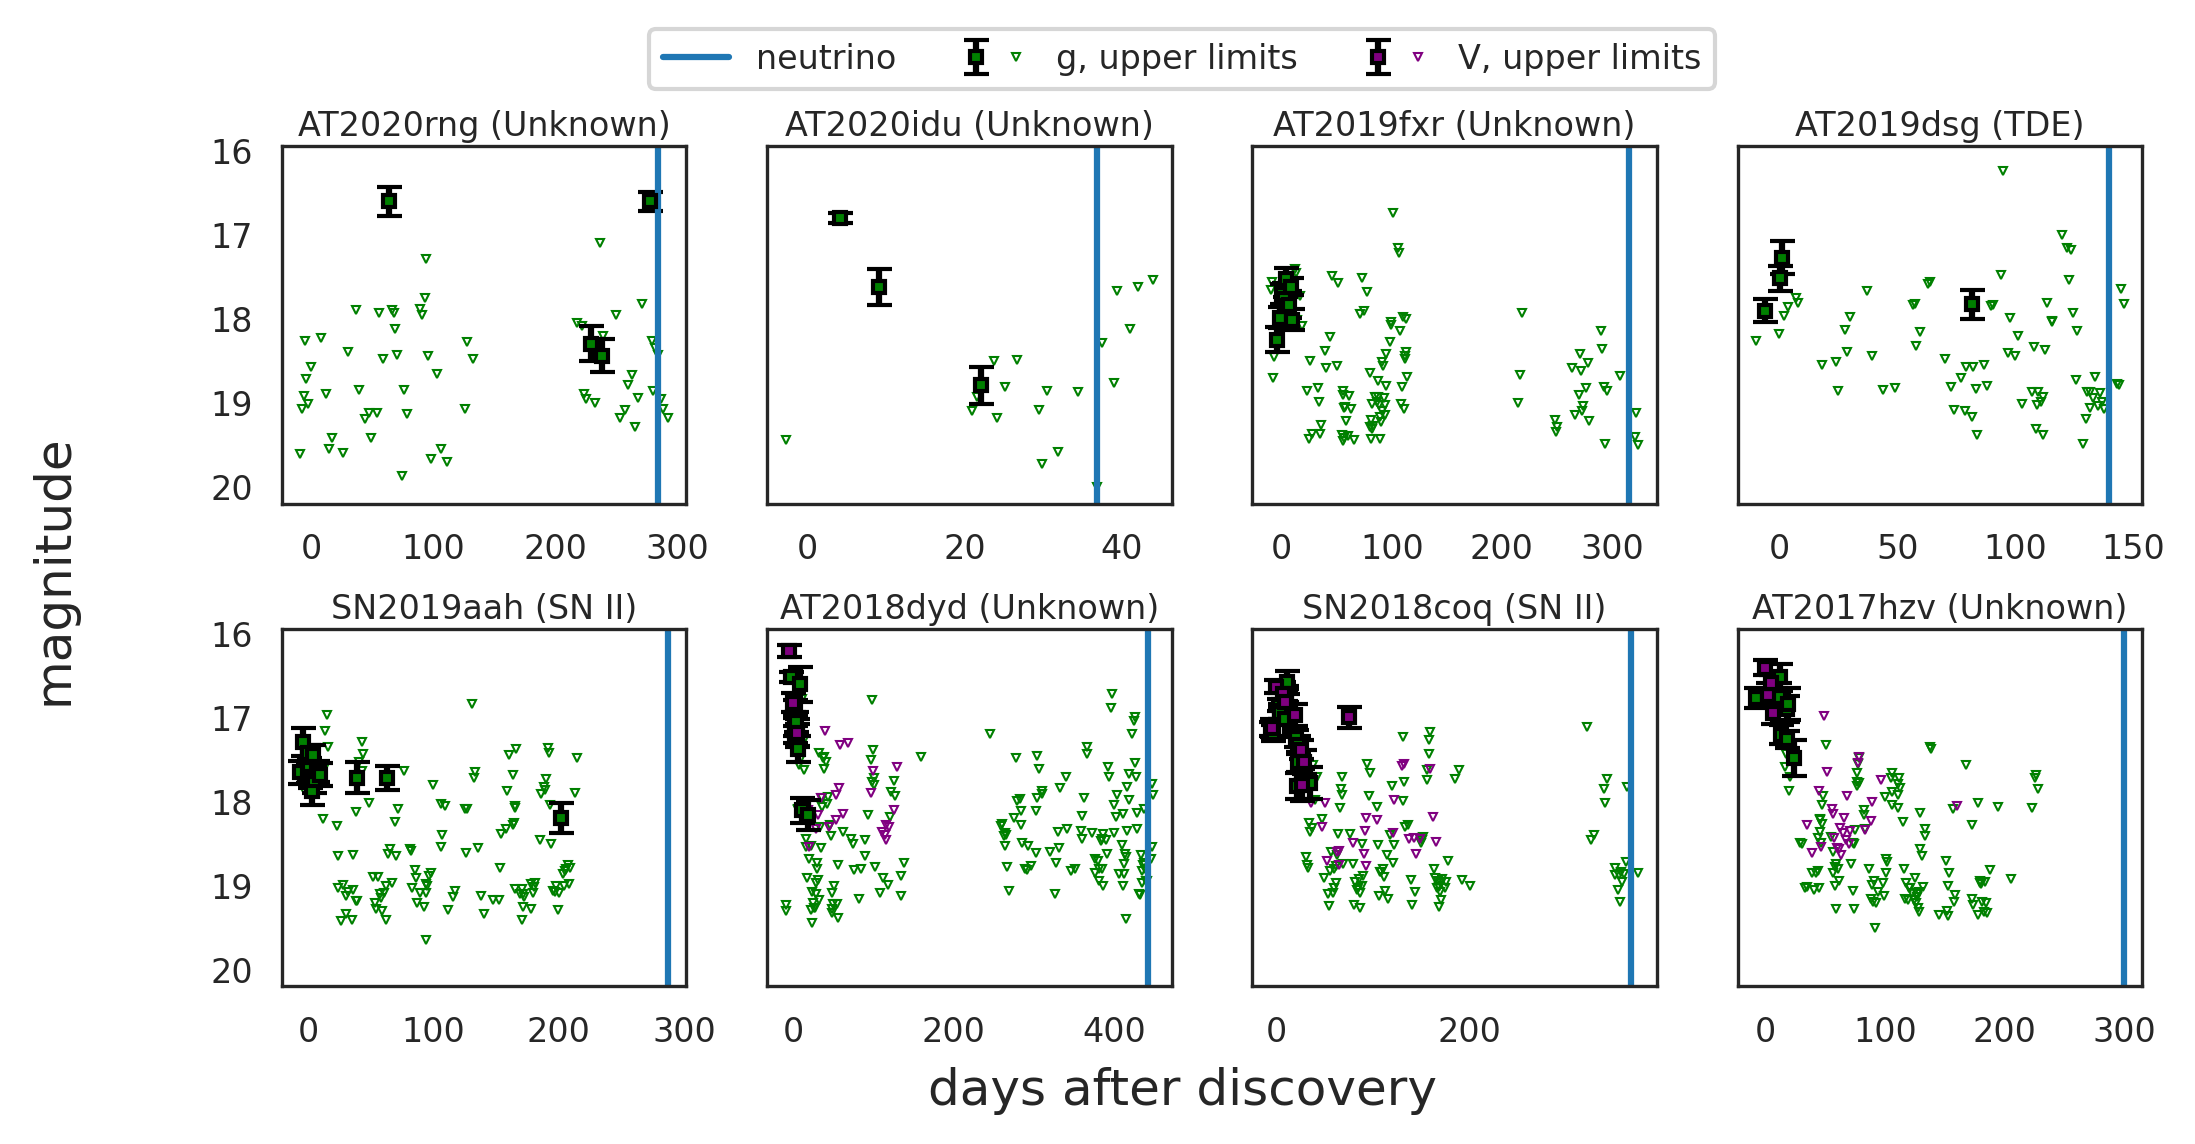

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(base_width*2, base_height*1.5), dpi=dpi, sharey='all', gridspec_kw={'hspace':0.35})
sigma=5
ylims = list()
for name, ax in zip(list(names) + ['TXS 0506+056', 'PKS 1502+106'], axs.flatten()):
    print(name)
    
    jdass, jdice, data, nu_name, ttype = get_lc(name)
    #fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
    conts = list()
    labels = list()
    for band, d in data.items():
        
        jd = d['JD'] - jdass
        mag = d['mag']
        err = d['mag_err']
        
        if len(jd):
            errm = (d['flux(mJy)'] < d.flux_err * sigma) | (err == 99.99)
            cont1 = ax.errorbar(jd[~errm], mag[~errm], yerr=err[~errm], color=bandcols[band], ls='',
                        markeredgecolor='k', ecolor='k', markersize=3, capsize=3, marker='s')
            cont2,  = ax.plot(jd[errm], mag[errm], marker='v', color=bandcols[band], ls='', markersize=2, 
                                 mfc=None, markeredgecolor=bandcols[band], mew=0.5, fillstyle='none', zorder=0)
            conts.append((cont1, cont2))
            labels.append(f"{band}, upper limits")

    ylims.append(ax.get_ylim())
#     ax.set_ylim([ylim[1], ylim[0]])
#     ax.set_ylabel('magnitude')
    mjd_ass = Time(jdass[0], format='jd').mjd
    mjd_ice = Time(jdice[0], format='jd').mjd
#     ax.set_xlabel(f'MJD - {mjd_ass:.0f}')
    line = ax.axvline(mjd_ice-mjd_ass)
#     ax.legend([line] + conts, [nu_name] + labels, handler_map={tuple: HandlerTuple(ndivide=None)})
#     ax.set_title(name, fontsize=big_fontsize-2)
    ax.text(.5,1.03, f'{name} ({ttype})',
        horizontalalignment='center',
        transform=ax.transAxes, fontsize=big_fontsize-2)
    
# fig.text(0.5, 0.04, 'common X', ha='center')
# fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
ylims = np.array(ylims)
axs[0][0].set_ylim(max(ylims[:,1]), min(ylims[:,0]))

fig.supxlabel('days after discovery')
fig.supylabel('magnitude')

fig.legend([line] + conts, ['neutrino'] + labels, handler_map={tuple: HandlerTuple(ndivide=None)}, bbox_to_anchor = (0.5,1.0),
            bbox_transform = fig.transFigure, loc='upper center', ncol=3)
# fig.tight_layout(pad=2)
fig.savefig(f'{candidates_lc_dir}/combined.pdf')
plt.show()
plt.close()


In [8]:
at2020rng_host_z = 0.027709
dl = cosmo.luminosity_distance(z=at2020rng_host_z).to(u.pc)
ab_mag = 16.5 - 5. * np.log10(dl/(10.*u.pc))
ab_mag.value

-18.990734881789635

no data for AT2020rng for V


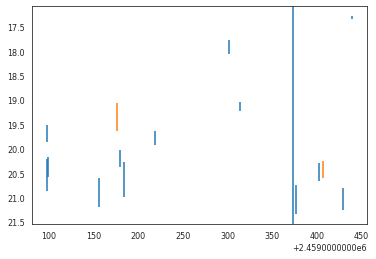

In [71]:
jdass, jdice, data, nu_name, ttype = get_lc('AT2020rng')
fig, ax = plt.subplots()
for fltr in ['r', 'g']:
    m = tab['filter'] == f"ZTF_{fltr}"
    d = tab[m]
    mag = zp[m] - 2.5*np.log10(f[m])
    mage = 1.0857* fu[m] / f[m]
    ax.errorbar(np.array(d['jd']).astype(float), mag, yerr=mage, ls='')
#     ax.plot(np.array(d['jd']).astype(float), mag, marker='x', ls='')
    
ax.axvline(jdice)
ylim = ax.get_ylim()
ax.set_ylim([ylim[1], ylim[0]])
    
plt.show()
plt.close()

In [49]:
np.float(tab['forcediffimflux'])


/tmp/ipykernel_222652/2669074079.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(tab['forcediffimflux'])


TypeError: only size-1 arrays can be converted to Python scalars

In [41]:
names

['index',
 'field',
 'ccdid',
 'qid',
 'filter',
 'pid',
 'info',
 'sciinpseeing',
 'scibckgnd',
 'scisigpix',
 'zpmaginpsci',
 'zpmaginpsciunc',
 'zpmaginpscirms',
 'clrcoeff',
 'clrcoeffunc',
 'ncalmatches',
 'exptime',
 'adpctdif1',
 'adpctdif2',
 'diffmaglim',
 'zpdiff',
 'programid',
 'jd',
 'rfid',
 'forcediffimflux',
 'forcediffimfluxunc',
 'forcediffimsnr',
 'forcediffimchisq',
 'forcediffimfluxap',
 'forcediffimfluxuncap',
 'forcediffimsnrap',
 'aperturecorr',
 'dnearestrefsrc',
 'nearestrefmag',
 'nearestrefmagunc',
 'nearestrefchi',
 'nearestrefsharp',
 'refjdstart',
 'refjdend',
 'procstatus']

In [69]:
tab['programid']

1
1
1
1
1
2
2
2
2
1
2
